# 46500 Probabilistic Methods in Wind Energy: Assignment 2
Moritz Herrmann s213890
Michael
Joan

## Introduction
blablabla

## Data Generation

The basis of each regression model is the data that it is trained and tested on. In this exercise it is not a fixed measurement set but it is sampled by distributions and transformed with functions. 

### Input

The input features $x$ are the 10min wind speed $u$, the internal standard deviation $\sigma$ representing the turbulence and the shear exponent $\alpha$. 
Whereas the wind speed is Weibull distributed with fixed parameters ($A=11.28, k=2$), the distribution of the other features depends on $u$ for each sample. 
The turbulence is lognormally distributed with a standard deviation of $\sigma_{\sigma} = 2.8 I_{ref}$ around its mean $\mu_\sigma=I_{ref} (0.75u+3.8)$ where $I_{ref}$ is constant 0.14. 
The shear exponent follows a Normal distribution with $\mu_\alpha (u)=0.088(log⁡(u)−1)$ and $\sigma_{\alpha} (u)=1/u$. The whole input data is generated with a Rosenblatt transformation which samples the distributions consecutively as described in the functions below. 

In [1]:
import numpy as np
import scipy.stats as stats

# Normal distribution
def NormalDist(task,x,mu=0,sigma=1):
    import numpy as np
    if task == 0: # PDF
        y = (1.0/(sigma*np.sqrt(2.0*np.pi)))*np.exp(-((x - mu)**2)/(2.0*(sigma**2)))
    elif task == 1: # Cumulative
        from scipy.special import erf
        y = 0.5*(1.0 + erf((x - mu)/(sigma*np.sqrt(2))))
    elif task == 2: # Inverse
        from scipy.special import erfinv
        y = mu + sigma*np.sqrt(2)*erfinv(2*x - 1)        
    return y

# Helper functions - lognormal distribution
def LogNormDist(task,x,mu,sigma):
    import numpy as np
    Eps   = np.sqrt(np.log( 1.0+(sigma/mu)**2 ) )
    Ksi   = np.log(mu)-0.5*Eps**2
    if task == 0: # PDF
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y = np.exp(-u*u/2.0)/(Eps*x*np.sqrt(2.0*np.pi))
    elif task == 1: # Cummulative
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y= NormalDist(1, u)
    elif task == 2: # Inverse
        y= np.exp(Ksi+Eps*NormalDist(2, x))
    
    return y

# sample wind data =[mu, sigma, alpha] as joint distribution with rosenblatt transformation
def rosenblatt(N, Aweib=11.28, Kweib=2, Iref=0.14, c_alpha=0.088):
    
    #--> for shear alpha
    MuAlphaFunc = lambda u: c_alpha*(np.log(u) - 1) #takes u, yields mu_alpha
    SigmaAlphaFunc = lambda u: 1/u

    #--> for turbulence sigma
    MuSigmaFunc = lambda u: Iref*(0.75*u + 3.8)
    SigmaSigmaU = 2.8*Iref

    #-->params for Weibull distribution of U
    Fu = np.random.rand(N) 
    u = stats.weibull_min.ppf(Fu,c = Kweib,scale = Aweib) # uses the weibull function to yield a large number of data

    # calculate params for other 2 distributions, mu and sigma each
    muSigma = MuSigmaFunc(u)
    sigmaSigma = SigmaSigmaU*np.ones(muSigma.shape)

    Fsigma = np.random.rand(N) # create new random sample
    sigmaU = LogNormDist(2,Fsigma,muSigma,sigmaSigma) #draw monte carlo samples from distibution

    muAlpha = MuAlphaFunc(u)
    sigmaAlpha = SigmaAlphaFunc(u)
    Falpha = np.random.rand(N)
    alpha = NormalDist(2,Falpha,muAlpha,sigmaAlpha)
    
    return np.transpose(np.array([u,sigmaU,alpha]))

### Output

The target data $y$ which is about to be predicted are the 10-minute extreme blade root flapwise moments. These loads depend on the input data by the following MysteriousLoadFunc which also models a random noise. 

In [2]:
def MysteriousLoadFunc(X):
    import numpy as np
    Alsq = np.array([-8.49821625e+03,  3.21111941e+03, -3.44642937e+03, -8.33496535e+02,
       -2.28585769e+02,  7.27203251e+03,  9.25677112e+02,  1.16755478e+02,
        1.18918605e+03,  5.07954840e+00, -3.79944018e+03, -3.99715920e+01,
        7.18288327e+01, -1.82188802e+02, -2.61134584e+00, -2.53566886e+02,
        1.11035167e+03,  8.03450614e+00, -1.49376926e+02,  6.50965086e+00])

    X1 = X[:,0]
    X2 = X[:,1]
    X3 = X[:,2]
    X0 = np.ones(X1.shape)
    Xmatrix = np.array((X0,X1,X2,X3,X1**2,X2**2,X1*X2,X1*X3,X2*X3,X1**3,X2**3,(X1**2)*X2, (X1**2)*X3, \
                       (X2**2)*X1,(X2**2)*X3,X1*X2*X3, X2**4, (X1**2)*(X2**2), X2**5, X2**6)).T

    Y = np.dot(Xmatrix,Alsq) + 50e3 + np.random.randn(X0.shape[0])*4.0e3
    return Y

With these functions 10000 data points is generated. The plots below deliver a first impression on about the distribution of $x$ and $y$. 

Text(0.5, 0, 'alpha')

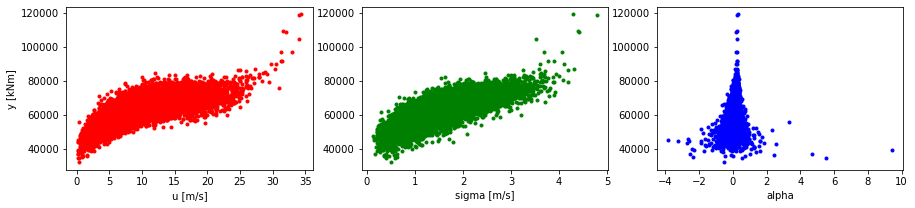

In [19]:
x = rosenblatt(10000)
y = MysteriousLoadFunc(x)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,3,figsize=[15,3])
axs[0].plot(x[:,0], y, '.r')
axs[0].set_xlabel('u [m/s]')
axs[0].set_ylabel('y [kNm]')
axs[1].plot(x[:,1], y, '.g')
axs[1].set_xlabel('sigma [m/s]')
axs[2].plot(x[:,2], y, '.b')
axs[2].set_xlabel('alpha')

## Model Selection

Now that the data is generated a model must be chosen. To acquire more experience with neural networks a Multi-layer Perceptron regressor from the sklearn.neural_network module has been chosen. Since a continuous quantity is estimated for the activation function a Rectified Linear Unit (ReLU) is chosen. Still, it needs to be decided how many hidden layers with how many nodes are necessary. In a quite heuristic approach three different settings are tried and compared in their computational effort and accuracy. These are "low" with two hidden layers and each 10 nodes, "medium" with two hidden layers and each 100 nodes and "high" with three layers and each 100 nodes. Additionally, it is investigated how a scaling improves the performance of the regression. 

As first step the regressors are initialized.

In [20]:
import sklearn.neural_network as nn

parameters = {'activation': 'relu',        # Rectified Linear Unit
              'learning_rate': 'adaptive', #
              'max_iter': 750,             #
              'random_state': 1,           # creates deterministic output over several executions
              'verbose': False,            # clutters output
              'early_stopping': True,      # stops when solution does not change a lot
              'n_iter_no_change': 10}

reg_low_unscaled    = nn.MLPRegressor(hidden_layer_sizes=(10,10), **parameters)
reg_medium_unscaled = nn.MLPRegressor(hidden_layer_sizes=(100,100), **parameters)
reg_high_unscaled   = nn.MLPRegressor(hidden_layer_sizes=(100,100,100), **parameters)
reg_low             = nn.MLPRegressor(hidden_layer_sizes=(10,10), **parameters)
reg_medium          = nn.MLPRegressor(hidden_layer_sizes=(100,100), **parameters)
reg_high            = nn.MLPRegressor(hidden_layer_sizes=(100,100,100), **parameters)

The second step is to scale the data and split it in the training and validation proportions. The normalization was performed before the splitting in order to have unified reference values. 

In [21]:
x_scaled = (x - x.mean(axis=0))/x.std(axis=0)
y_scaled = (y - y.mean() ) / y.std()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.25, random_state=1, shuffle=True)
x_train_unscaled, x_test_unscaled, y_train_unscaled, y_test_unscaled = train_test_split(x, y, test_size=0.25, random_state=1, shuffle=True)

Now, everything is prepared to train the regressors. In order to compare the accuracy the $R^2$ scores a.k.a. coefficient of determination is calculated. 

In [22]:
reg_low_unscaled.fit(x_train_unscaled, y_train_unscaled)
reg_medium_unscaled.fit(x_train_unscaled, y_train_unscaled)
reg_high_unscaled.fit(x_train_unscaled, y_train_unscaled)
reg_low.fit(x_train, y_train)
reg_medium.fit(x_train, y_train)
reg_high.fit(x_train, y_train)

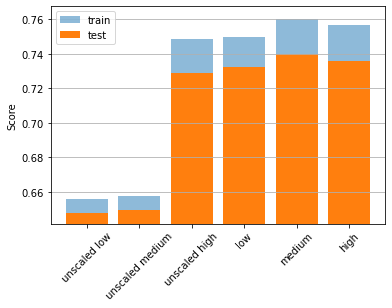

In [37]:
score_low_unscaled    = reg_low_unscaled.score(x_test_unscaled, y_test_unscaled)
score_medium_unscaled = reg_medium_unscaled.score(x_test_unscaled, y_test_unscaled)
score_high_unscaled   = reg_high_unscaled.score(x_test_unscaled, y_test_unscaled)
score_low             = reg_low.score(x_test, y_test)
score_medium          = reg_medium.score(x_test, y_test)
score_high            = reg_high.score(x_test, y_test)

score_low_unscaled_train    = reg_low_unscaled.score(x_train_unscaled, y_train_unscaled)
score_medium_unscaled_train = reg_medium_unscaled.score(x_train_unscaled, y_train_unscaled)
score_high_unscaled_train   = reg_high_unscaled.score(x_train_unscaled, y_train_unscaled)
score_low_train             = reg_low.score(x_train, y_train)
score_medium_train          = reg_medium.score(x_train, y_train)
score_high_train            = reg_high.score(x_train, y_train)

scores_train = [score_low_unscaled_train, score_medium_unscaled_train, score_high_unscaled_train, score_low_train, score_medium_train, score_high_train]
scores_test = [score_low_unscaled, score_medium_unscaled, score_high_unscaled, score_low, score_medium, score_high]
names = ['unscaled low', 'unscaled medium', 'unscaled high', 'low', 'medium', 'high']

plt.bar(range(6), scores_train, alpha=0.5, label='train')
plt.bar(range(6), scores_test, label='test')
plt.xticks(range(6), labels=names, rotation=45)
plt.ylabel('Score')
plt.ylim([0.99 * min(scores_test), 1.01*max(scores_train)])
plt.grid(axis='y')
plt.legend();

Although in other regression exercises $R^2$ in the high 90% were achieved the present scores are not disappointing but they are due to the noise in the data. Even if the model predicts the "correct", over many data sets averaged load for all features, for one realization there is still a significant deviation. 

Comparing the $R^2$ scores, at first glimpse it is obvious that a scaling improves the accuracy of the model. It is observed that also the necessary number of iterations i.e. the computing time is decreasing. Even a relatively complex model is not able to reach the accuracy of a simple model with normalized data. 

Focusing on the regressions with scaled data, it is not obvious what the best option is because the numbers are close and the rangking is changing over different data sets. Most of the times the simple model is the worst and often the "medium" model is superior to the "high" model. It is surprising that even the training error is larger for the "high" model which indicates that the lack in accuracy is not due to overfitting. 

To get a better understanding of the three more models around the "high" model are trained and evaluated. 

In [38]:
reg_high0 = nn.MLPRegressor(hidden_layer_sizes=(500,500), **parameters)
reg_high1 = nn.MLPRegressor(hidden_layer_sizes=(500,500,500), **parameters)
reg_high2 = nn.MLPRegressor(hidden_layer_sizes=(100,100,100,100), **parameters)

In [41]:
reg_high0.fit(x_train, y_train)
reg_high1.fit(x_train, y_train)
reg_high2.fit(x_train, y_train);

MLPRegressor(early_stopping=True, hidden_layer_sizes=(500, 500),
             learning_rate='adaptive', max_iter=750, random_state=1)

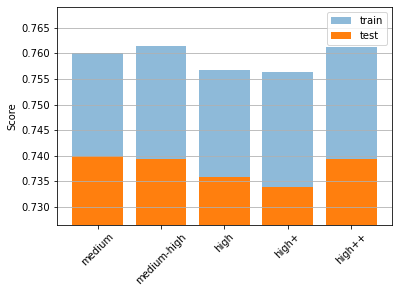

In [43]:
score_high0 = reg_high0.score(x_test, y_test)
score_high1 = reg_high1.score(x_test, y_test)
score_high2 = reg_high2.score(x_test, y_test)

score_high0_train = reg_high0.score(x_train, y_train)
score_high1_train = reg_high1.score(x_train, y_train)
score_high2_train = reg_high2.score(x_train, y_train)

scores_train = [score_medium_train, score_high0_train, score_high_train, score_high1_train, score_high2_train]
scores_test = [score_medium, score_high0, score_high, score_high1, score_high2]
names = ['medium', 'medium-high', 'high', 'high+', 'high++']

plt.bar(range(5), scores_train, alpha=0.5, label='train')
plt.bar(range(5), scores_test, label='test')
plt.xticks(range(5), labels=names, rotation=45)
plt.ylabel('Score')
plt.ylim([0.99 * min(scores_test), 1.01*max(scores_train)])
plt.grid(axis='y')
plt.legend();

There has not been any significant improvement for the new models. Some of them perform even worse. Perhaps, the currently achieved accuracy is already the maximum what is capable to capture with a deterministic model. In order to stick to the simplest approach the "medium" regressor is chosen for the rest of this exercise. It is not significantly worse than the more complex models (sometimes even better) and is quicker in its training. 

In [ ]:
# plot y_pred and y_true

In [15]:
# predict some data
y_pred = reg_medium.predict(test_in_scaled)

<Figure size 432x288 with 0 Axes>

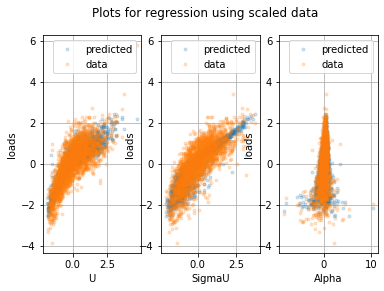

In [23]:
# plot the results for the regression using scaled
plt.figure()
fig, axs = plt.subplots(1,3)
fig.suptitle("Plots for regression using scaled data")

axs[0].plot(test_in_scaled[:,0], y_pred, '.', label="predicted",alpha=0.2)
axs[0].plot(test_in_scaled[:,0], test_out_scaled, '.', label="data",alpha=0.2)
axs[0].set_xlabel("U")

axs[1].plot(test_in_scaled[:,1], y_pred, '.', label="predicted",alpha=0.2)
axs[1].plot(test_in_scaled[:,1], test_out_scaled, '.', label="data",alpha=0.2)
axs[1].set_xlabel("SigmaU")

axs[2].plot(test_in_scaled[:,2], y_pred, '.', label="predicted",alpha=0.2)
axs[2].plot(test_in_scaled[:,2], test_out_scaled, '.', label="data",alpha=0.2)
axs[2].set_xlabel("Alpha")

for ax in axs:
    ax.legend()
    ax.grid()
    ax.set_ylabel("loads")

<Figure size 432x288 with 0 Axes>

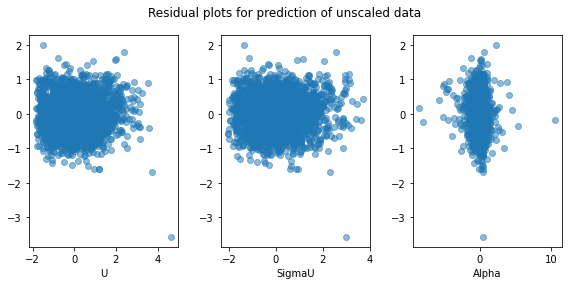

In [26]:
#Do some residual plots: 
# plot the results for the regression using unscaled
plt.figure()
#plt.tight_layout()
fig, axs = plt.subplots(1,3,figsize=(8,4))
fig.suptitle("Residual plots for prediction of unscaled data")
y_err = (y_pred - test_out_scaled)#/test_out_scaled
axs[0].scatter(test_in_scaled[:,0],y_err,label="predicted",alpha=0.5)
#axs[0].scatter(test_in[:,0],test_out,label="data",alpha=0.5)
axs[0].set_xlabel("U")

axs[1].scatter(test_in_scaled[:,1],y_err,label="predicted",alpha=0.5)
#axs[1].scatter(test_in[:,1],test_out,label="data",alpha=0.5)
axs[1].set_xlabel("SigmaU")

axs[2].scatter(test_in_scaled[:,2],y_err,label="predicted",alpha=0.5)
#axs[2].scatter(test_in[:,2],test_out,label="data",alpha=0.3)
axs[2].set_xlabel("Alpha")
fig.tight_layout(w_pad=1.8)

In [30]:
# Scores have  been computed before. But now, let's calculate some more error terms for the medium unscaled model
# r-square, RMS error, MAE)

# R² adjusted corrects for multiple parameters 
r_squared = score_medium # dummy value 
n= len(test_out) # number of samples
k= test_in.shape[1] # number of parameters
r_adjusted =1-  ( ((1-r_squared)*(n-1)) / (n-k-1 ) )
print(f"R_squared is {r_squared}, \t R squared adjusted is; {r_adjusted}")

#RMSE ;sqrt( (f-o)^2 ) 
rmse = np.sqrt((1/len(test_out))*np.sum(np.multiply(y_pred-test_out_scaled,y_pred-test_out_scaled))) # again the question is, whether to calculate it on the full data set or on the test data
#rmse = np.std(y_pred - test_out_scaled) # would also work
print(f"The root mean square error is : {rmse}")

#MAE 
mae = (1/len(test_out_scaled))*np.sum(np.abs(y_pred - test_out_scaled))

print(f"The mean absolute error is : {mae}")

R_squared is 0.7473007311196762, 	 R squared adjusted is; 0.7469970060368873
The root mean square error is : 0.5074370152279913
The mean absolute error is : 0.4014500989439528


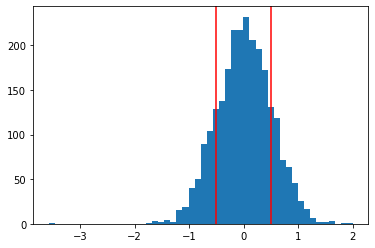

In [31]:
# It appears, that there is only slight difference between both R² values. It is not clear atm, whether these values can reallly be compared. 
# Maybe these values work better to compare different regressions, instead of being representative on its own. 
# The rmse as a number does not really say something on its own. maybe visualize it, using a histogram: 
plt.figure()
plt.hist(y_pred - test_out_scaled,bins=50)
plt.axvline(rmse,color='r')
plt.axvline(-rmse,color='r')
#Showing the histogram of the distribution of absolute errors, and the rmse (standard deviation)  